## This code takes the college basketball data and models it using logistic regression

In [1]:
#import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import StratifiedKFold
from hyperopt import fmin, tpe, anneal, hp, STATUS_OK, Trials, space_eval
import hyperopt.pyll.stochastic
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        probas = model.predict_proba(test_features)[:, 1]
        
        print('Area Under the Curve =', roc_auc_score(test_labels, probas))
        
        
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    probas1 = model1.predict_proba(test_features1)[:, 1]
    probas2 = model2.predict_proba(test_features2)[:, 1]
    
    auc1 = roc_auc_score(test_labels, probas1)
    auc2 = roc_auc_score(test_labels, probas2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    acc_diff = accuracy2 - accuracy1
    auc_diff = auc2 - auc1
    
    
    if acc_diff > 0:
        result_acc = 'Accuracy: Model 2 better'
    elif acc_diff == 0:
        result_acc = "Accuracy: Models perform the same"
    else:
        result_acc = "Accuracy: Model 1 better"
        
    if auc_diff > 0:
        result_auc = 'AUC: Model 2 better'
    elif auc_diff == 0:
        result_auc = "AUC: Models perform the same"
    else:
        result_auc = "AUC: Model 1 better"
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(acc_diff),"    ",result_acc)
    print('AUC: ',(auc1),"   ",(auc2),"   ",(auc_diff),"    ",result_auc)
    
    
def evaluate_test(models, test_features, test_outcomes, sort_var = 'acc'):
    
    full_result = pd.DataFrame()
    
    for x in range(len(models)):
          
        predictions = models[x].predict(test_features[x])
        probs = models[x].predict_proba(test_features[x])[:, 1]
        
        auc = roc_auc_score(test_outcomes, probs)
        accuracy = sum(predictions == test_outcomes)/len(test_outcomes)
        
        current_result = pd.DataFrame({'model_name': [name_of_object(models[x])],
                                       'model':[models[x]],
                                       'data_name': [name_of_object(test_features[x])],
                                       'data':[test_features[x].to_dict()],
                                       'acc':[accuracy], 'auc':[auc]})
        
        full_result = full_result.append(current_result, ignore_index = True)
        
    full_result.reset_index(drop=True, inplace = True)
        
    full_result['acc_rank'] = full_result['acc'].rank(ascending = False)
    full_result['auc_rank'] = full_result['auc'].rank(ascending = False)
    
    #if sort_var == 'acc':
        
    full_result.sort_values(by = ['acc_rank','auc_rank'], inplace=True)
        
    #elif sort_var == 'auc': 
    
    #    full_result.sort_values(by = ['auc_rank'], inplace=True)
        
    #else:
    
    #    full_result = full_result
        
    return(full_result)

def name_of_object(arg):
    # check __name__ attribute (functions)
    try:
        return arg.__name__
    except AttributeError:
        pass

    for name, value in globals().items():
        if value is arg and not name.startswith('_'):
            return name

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [3]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [4]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [5]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [6]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [7]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [8]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [9]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [10]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [11]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [12]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [13]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [14]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [15]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [16]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT']

#fields_to_keep = []



In [17]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [18]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 59)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [19]:
#Create outcome data

y = full_data_adv['W/L'].values

y.shape

(10693,)

In [20]:
#Create training, validation, and test data

train_ratio = 0.60
validation_ratio = 0.25
test_ratio = 0.15


# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= test_ratio,
                                                    stratify = y,
                                                    random_state = 4242)

 #test is now 10% of the initial data set
 #validation is now 20% of the initial data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=validation_ratio/(train_ratio + validation_ratio),
                                                 stratify = y_train,
                                                 random_state = 4242) 

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])
print(y_train.sum()/len(y_train), y_val.sum()/len(y_val), y_test.sum()/len(y_test))

(6415, 59) (2674, 59) (1604, 59)
0.5999251847002712 0.25007013934349576 0.15000467595623304
0.5016367887763056 0.5014958863126402 0.5018703241895262


In [21]:
#Standardizing the predictor variables into Z scores

#take categorical variables and one-hot encode
dummy_train = X_train[['Location_A','Location_H','Location_N']]
dummy_train.reset_index(drop = True, inplace = True)
dummy_val = X_val[['Location_A','Location_H','Location_N']]
dummy_val.reset_index(drop = True, inplace = True)
dummy_test = X_test[['Location_A','Location_H','Location_N']]
dummy_test.reset_index(drop = True, inplace = True)

#create subset of data with just continuous variables
X_train1 = X_train.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_val1 =  X_val.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_test1 =  X_test.drop(['Location_A','Location_H','Location_N'], axis = 1)

#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#combine continuous and categorical variables
X_train_d = pd.concat([X_train_std, dummy_train], axis = 1)
X_val_d = pd.concat([X_val_std, dummy_val], axis = 1)
X_test_d = pd.concat([X_test_std, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full = X_train_d.drop(['Location_N'], axis = 1)
X_val_full = X_val_d.drop(['Location_N'], axis = 1)
X_test_full = X_test_d.drop(['Location_N'], axis = 1)

## Running a basic logistic regression model and examining the results

In [22]:
#create basic logistic regression object
logreg = LogisticRegression(random_state = 42, max_iter = 1000)

In [23]:
#fit basic logistic regression model to training data
logreg.fit(X_train_full,y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.681750186985789 

Classification Report

              precision    recall  f1-score   support

           0     0.6829    0.6752    0.6790      1333
           1     0.6807    0.6883    0.6845      1341

    accuracy                         0.6818      2674
   macro avg     0.6818    0.6817    0.6817      2674
weighted avg     0.6818    0.6818    0.6817      2674



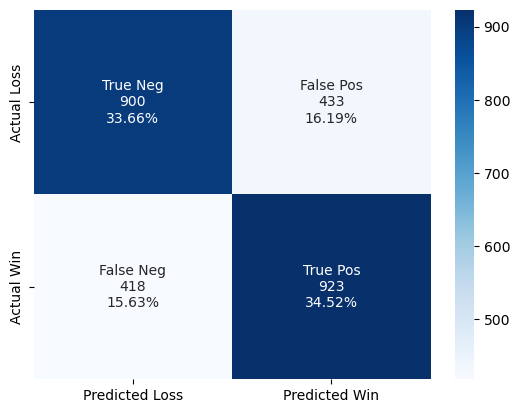

Area Under the Curve = 0.743444250324326


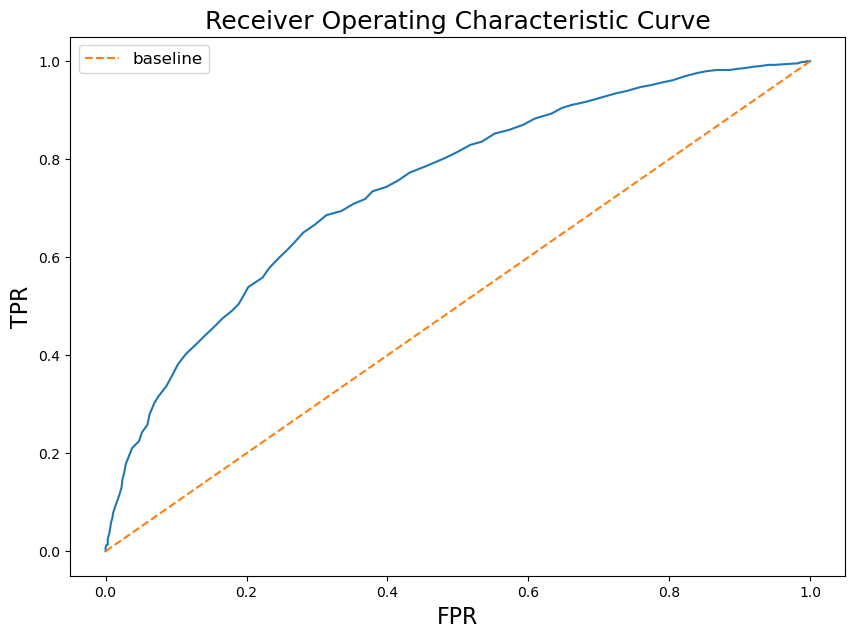

In [24]:
#evaluate trained logistic regression model on test data

evaluate_classification(logreg, X_val_full, y_val, extra = True)

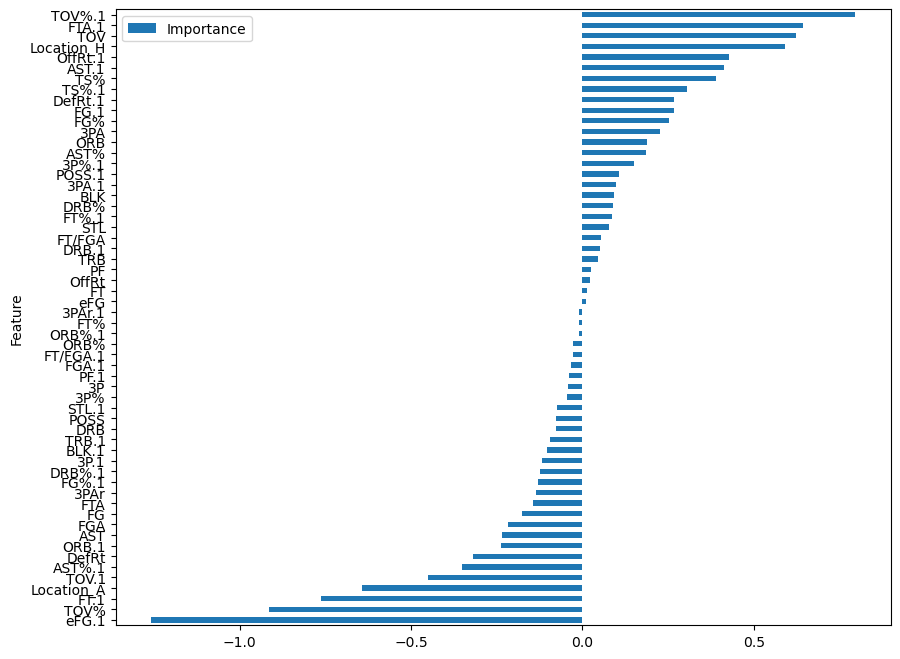

In [25]:
#examining variable importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [26]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
44       eFG.1   -1.258899
17        TOV%   -0.913198
34        FT.1   -0.763180
56  Location_A   -0.642363
42       TOV.1   -0.451678
49      AST%.1   -0.350298
27       DefRt   -0.319740
37       ORB.1   -0.236183
11         AST   -0.233867
1          FGA   -0.216042
0           FG   -0.177702
7          FTA   -0.145469
23        3PAr   -0.136688
30       FG%.1   -0.130909
48      DRB%.1   -0.122870
31        3P.1   -0.117072
41       BLK.1   -0.104260
38       TRB.1   -0.095262
24         DRB   -0.077432
25        POSS   -0.075977
40       STL.1   -0.074915
5          3P%   -0.046121
3           3P   -0.042941
43        PF.1   -0.038849
29       FGA.1   -0.034422
47    FT/FGA.1   -0.028587
18        ORB%   -0.027592
46      ORB%.1   -0.011388
8          FT%   -0.010638
51      3PAr.1   -0.008761
16         eFG    0.011022
6           FT    0.012632
26       OffRt    0.023118
15          PF    0.025280
10         TRB    0.045470
52       DRB.1    0.051754
1

## Note: Many of out variables are not that important, so we can probably remove some of them later, but first lets optimize the model for this full set of variables

## Now lets use hyperopt to optimize the Logistic Regression

In [27]:
#create function to optimize

def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    model.fit(X_train_full, y_train)
    y_pred = model.predict(X_val_full)
    return accuracy_score(y_val, y_pred)


In [28]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['lbfgs',
                                  'liblinear',
                                  'saga',
                                  'sag']),
    'C': hp.uniform('C', 0.0, 0.1),
    'max_iter': 5000,
    'random_state': 42,
}


In [29]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                     
0.6866118175018698                                                            
{'C': 0.06201189976766411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
1                                                                             
new best:                                                                     
0.6896035901271503                                                            
{'C': 0.021221711699333526, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
4                                                                             
new best:                                                                     
0.6903515332834704                                                            
{'C': 0.010308206613656157, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
18                                                               

In [30]:
#examine best parameters
best1 = space_eval(space, best)
best1

{'C': 0.010308206613656157,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga'}

In [31]:
#train model using best parameters from search
hyp_logreg = LogisticRegression(C = best1['C'],
                  max_iter = best1['max_iter'],
                  penalty = best1['penalty'],
                  solver = best1['solver'],
                  random_state =  best1['random_state'])

hyp_logreg.fit(X_train_full, y_train)

LogisticRegression(C=0.010308206613656157, max_iter=5000, random_state=42,
                   solver='saga')

In [32]:
#examine accuracy on training data
y_pred = hyp_logreg.predict(X_train_full)
print('Training Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3197
           1       0.68      0.68      0.68      3218

    accuracy                           0.68      6415
   macro avg       0.68      0.68      0.68      6415
weighted avg       0.68      0.68      0.68      6415



In [33]:
#examine accuracy on test data
y_pred = hyp_logreg.predict(X_val_full)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.68      0.69      1333
           1       0.69      0.70      0.69      1341

    accuracy                           0.69      2674
   macro avg       0.69      0.69      0.69      2674
weighted avg       0.69      0.69      0.69      2674



Model Performance

Accuracy =  0.6903515332834704 

Classification Report

              precision    recall  f1-score   support

           0     0.6926    0.6812    0.6868      1333
           1     0.6882    0.6995    0.6938      1341

    accuracy                         0.6904      2674
   macro avg     0.6904    0.6903    0.6903      2674
weighted avg     0.6904    0.6904    0.6903      2674



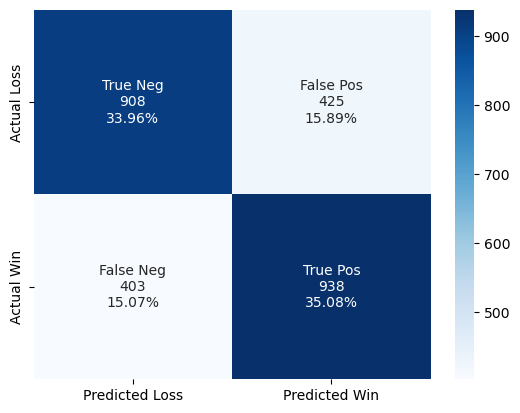

Area Under the Curve = 0.745970608983342


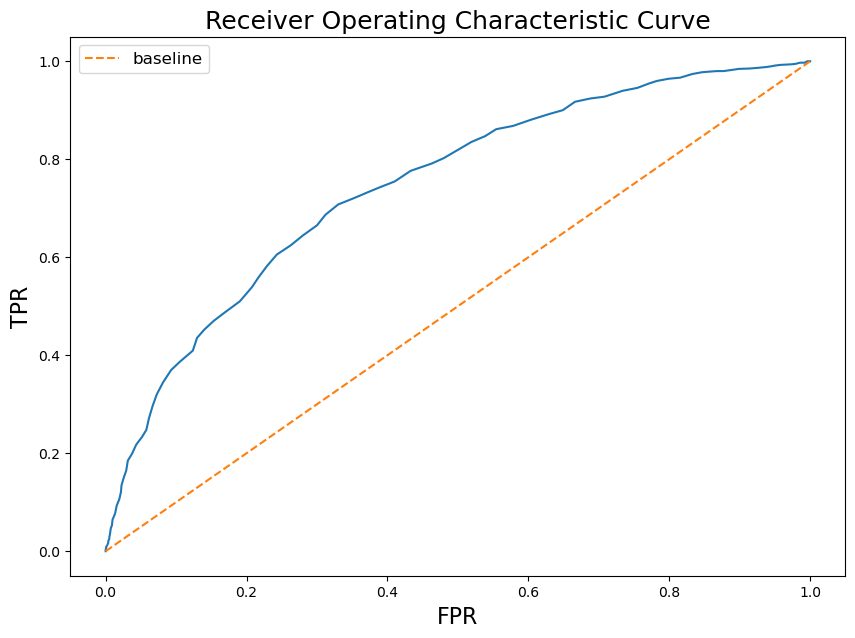

In [34]:
#further investigate accuracy on test data
evaluate_classification(hyp_logreg, X_val_full, y_val, extra = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

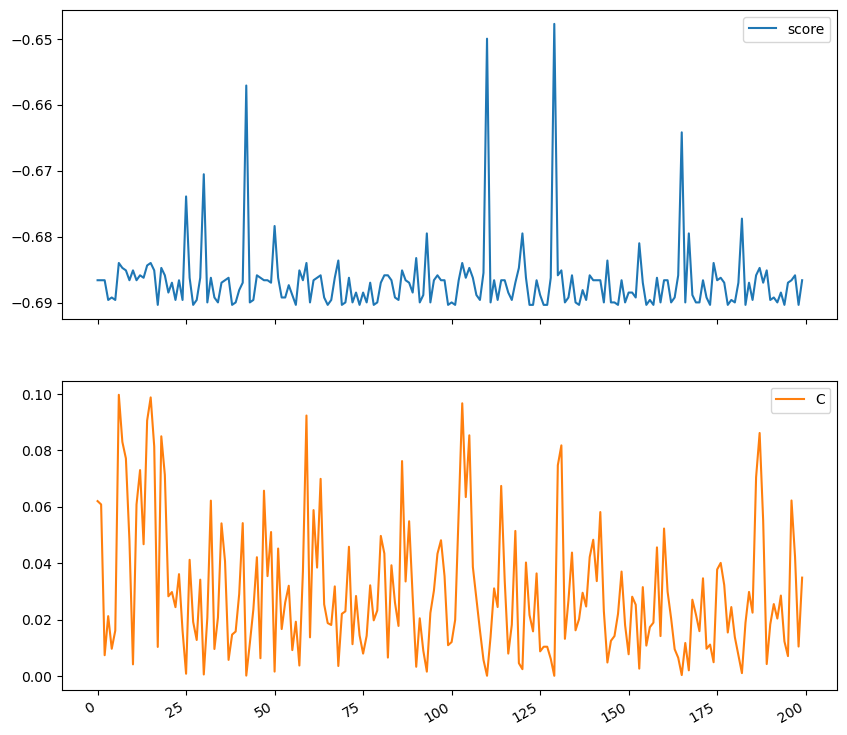

In [35]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

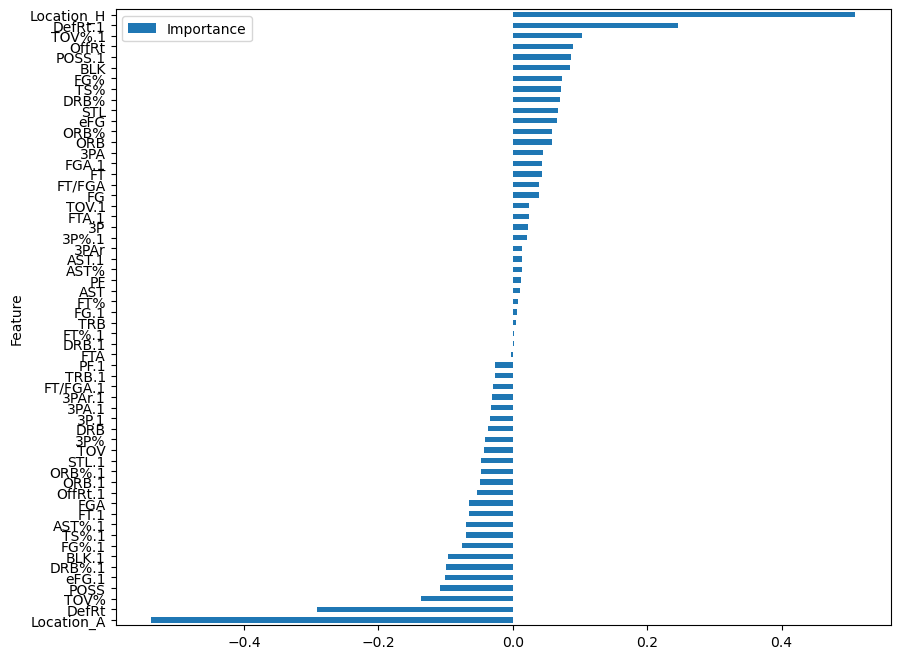

In [36]:
#examining variable importance
coefficients = hyp_logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [37]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
56  Location_A   -0.538838
27       DefRt   -0.291437
17        TOV%   -0.136828
25        POSS   -0.108205
44       eFG.1   -0.100740
48      DRB%.1   -0.099000
41       BLK.1   -0.097006
30       FG%.1   -0.075070
50       TS%.1   -0.070354
49      AST%.1   -0.069432
34        FT.1   -0.064926
1          FGA   -0.064871
54     OffRt.1   -0.053766
37       ORB.1   -0.048461
46      ORB%.1   -0.047268
40       STL.1   -0.046911
14         TOV   -0.042415
5          3P%   -0.041736
24         DRB   -0.036798
31        3P.1   -0.034724
32       3PA.1   -0.033195
51      3PAr.1   -0.030956
47    FT/FGA.1   -0.030120
38       TRB.1   -0.026412
43        PF.1   -0.026178
7          FTA   -0.002622
52       DRB.1    0.001042
36       FT%.1    0.001529
10         TRB    0.004449
28        FG.1    0.005550
8          FT%    0.007107
11         AST    0.010674
15          PF    0.012708
21        AST%    0.013101
39       AST.1    0.014060
23        3PAr    0.014107
3

In [38]:
#compare original logistic regression to optimized
compare_classification(logreg, hyp_logreg, X_val_full, X_val_full, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.681750186985789     0.6903515332834704     0.00860134629768139      Accuracy: Model 2 better
AUC:  0.743444250324326     0.745970608983342     0.0025263586590159592      AUC: Model 2 better


## The optimized model performs better than the base model and we see that the variable importance even more so shows there are only a few important variables

## It may be the case that some variables are not that important, as a result we can try using Recrusive Feature Selection to narrow down our variable list

In [39]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
LR_estimator = LogisticRegression(random_state=42, max_iter = 5000)
LR_select = RFECV(LR_estimator, step=1, cv=5, n_jobs = -1)
LR_selector = LR_select.fit(X_train_full, y_train)


In [40]:
#examining how many of the original features were retained
(LR_selector.support_).sum()

51

In [41]:
#examining which features were retained
X_train_full.columns[LR_selector.support_]

Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FTA', 'ORB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%', 'TS%',
       '3PAr', 'DRB', 'POSS', 'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1',
       '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1',
       'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1', 'FT/FGA.1',
       'DRB%.1', 'AST%.1', 'TS%.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H'],
      dtype='object')

In [42]:
#examining which features were removed
X_train_full.columns[~LR_selector.support_]

Index(['FT', 'FT%', 'PF', 'eFG', 'OffRt', 'ORB%.1', '3PAr.1'], dtype='object')

In [43]:
#creating training data the contains only the retained features
X_train_full_rfe = X_train_full[X_train_full.columns[LR_selector.support_]]
X_val_full_rfe = X_val_full[X_val_full.columns[LR_selector.support_]]
X_test_full_rfe = X_test_full[X_train_full.columns[LR_selector.support_]]

In [44]:
#creating a base logistic regression object
logreg_rfe = LogisticRegression(random_state = 42, max_iter = 5000)

In [45]:
#fitting the model to the subset of features
logreg_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(max_iter=5000, random_state=42)

Model Performance

Accuracy =  0.681750186985789 

Classification Report

              precision    recall  f1-score   support

           0     0.6829    0.6752    0.6790      1333
           1     0.6807    0.6883    0.6845      1341

    accuracy                         0.6818      2674
   macro avg     0.6818    0.6817    0.6817      2674
weighted avg     0.6818    0.6818    0.6817      2674



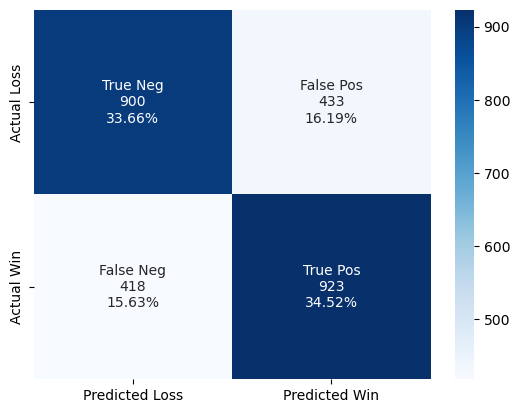

Area Under the Curve = 0.7431650977621362


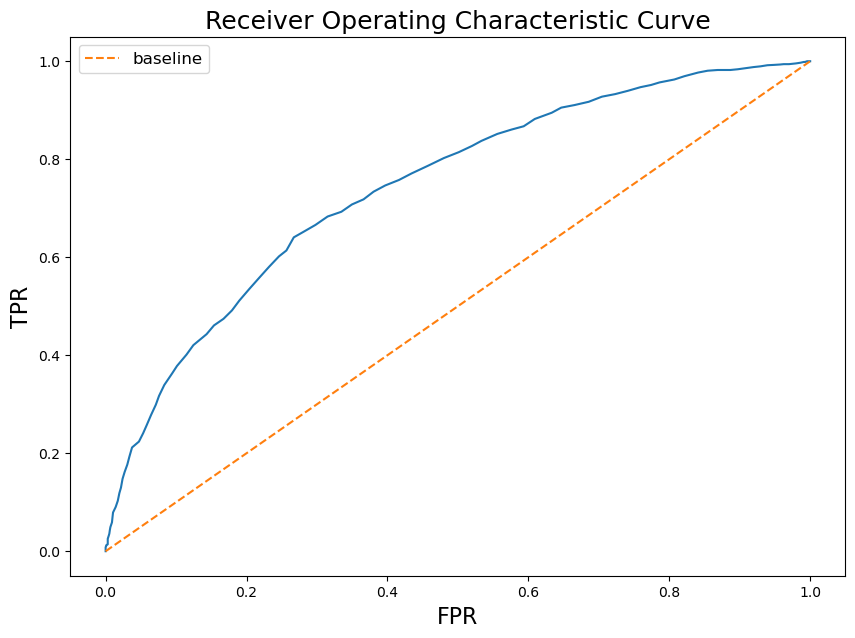

In [46]:
#evaluating reduced features model
evaluate_classification(logreg_rfe, X_val_full_rfe, y_val, extra = True)

In [47]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, logreg_rfe, X_val_full, X_val_full_rfe, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6903515332834704     0.681750186985789     -0.00860134629768139      Accuracy: Model 1 better
AUC:  0.745970608983342     0.7431650977621362     -0.0028055112212057587      AUC: Model 1 better


## The optimized logistic regression with the full variable set model performs better
## Lets also try optimizing the RFE model

In [48]:
#create function to optimize

def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    model.fit(X_train_full_rfe, y_train)
    y_pred = model.predict(X_val_full_rfe)
    return accuracy_score(y_val, y_pred)

In [49]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['saga',
                                   'liblinear',
                                  'lbfgs',
                                  'sag']),
    'C': hp.uniform('C', 0.0,0.1),
    'max_iter': 5000,
    'random_state': 42,
}


In [50]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                     
0.6836200448765893                                                            
{'C': 0.06201189976766411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
1                                                                             
new best:                                                                     
0.6839940164547494                                                            
{'C': 0.06082491621711366, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag'}
2                                                                             
new best:                                                                     
0.6881077038145101                                                            
{'C': 0.007366102545052411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
3                                                                   

In [51]:
#examine best parameters
best2 = space_eval(space, best)
best2

{'C': 0.012638465688060376,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}

In [52]:
#train model using best parameters
hyp_rfe = LogisticRegression(C = best2['C'],
                  max_iter = best2['max_iter'],
                  penalty = best2['penalty'],
                  solver = best2['solver'],
                  random_state =  best2['random_state'])

hyp_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(C=0.012638465688060376, max_iter=5000, random_state=42,
                   solver='liblinear')

In [53]:
y_pred = hyp_rfe.predict(X_train_full_rfe)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3197
           1       0.68      0.68      0.68      3218

    accuracy                           0.68      6415
   macro avg       0.68      0.68      0.68      6415
weighted avg       0.68      0.68      0.68      6415



In [54]:
y_pred = hyp_rfe.predict(X_val_full_rfe)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.68      0.69      1333
           1       0.69      0.70      0.69      1341

    accuracy                           0.69      2674
   macro avg       0.69      0.69      0.69      2674
weighted avg       0.69      0.69      0.69      2674



Model Performance

Accuracy =  0.6903515332834704 

Classification Report

              precision    recall  f1-score   support

           0     0.6914    0.6842    0.6878      1333
           1     0.6893    0.6965    0.6929      1341

    accuracy                         0.6904      2674
   macro avg     0.6904    0.6903    0.6903      2674
weighted avg     0.6904    0.6904    0.6903      2674



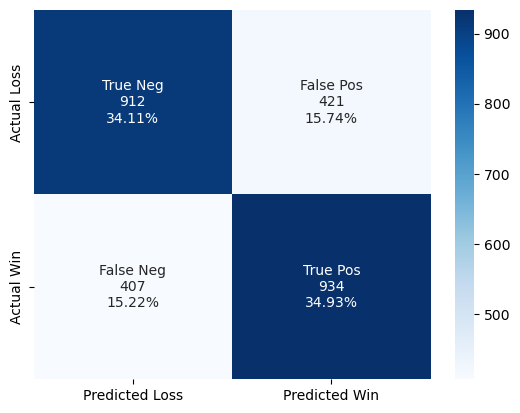

In [55]:
evaluate_classification(hyp_rfe, X_val_full_rfe, y_val)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

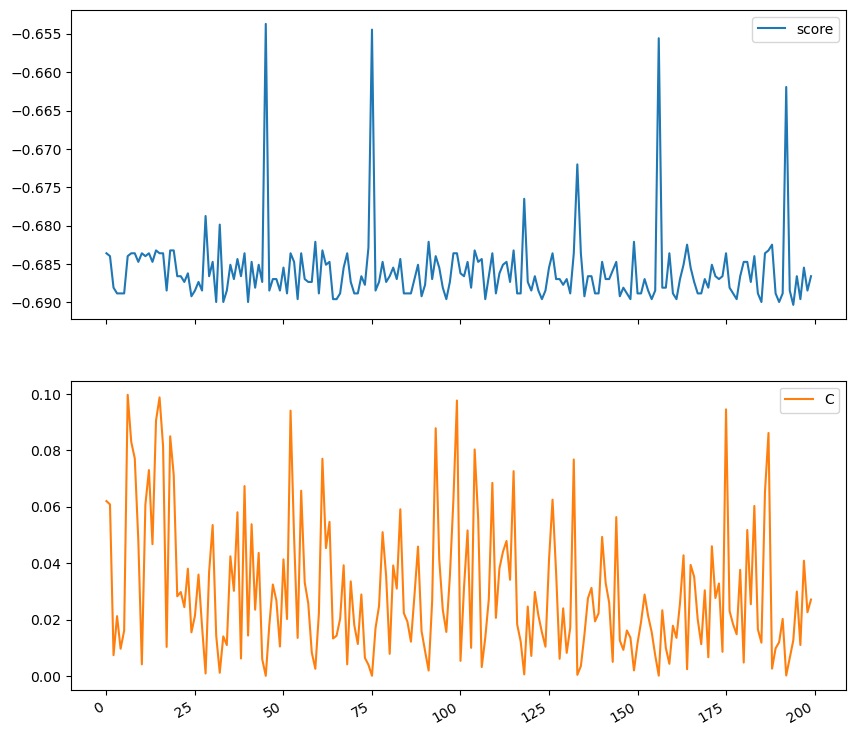

In [56]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

In [57]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, hyp_rfe, X_val_full, X_val_full_rfe, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6903515332834704     0.6903515332834704     0.0      Accuracy: Models perform the same
AUC:  0.745970608983342     0.7460629139387754     9.230495543344208e-05      AUC: Model 2 better


## The optimized logistic regression model using RFE performs the best so far.

## Next we should examine if there are high correlations between certain variables by first visually inspecting a correlation plot

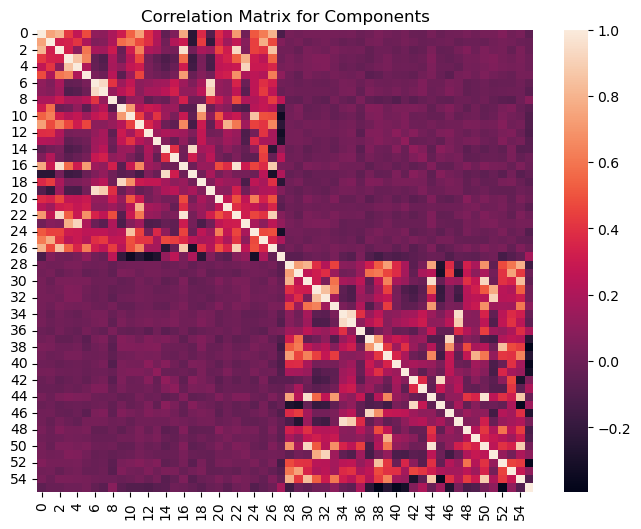

In [58]:
#examining the correlations between the standardized continuous variables
fig, ax = plt.subplots(figsize=(8,6))
corr_mat = np.corrcoef(X_train_std.transpose())
sns.heatmap(corr_mat)
ax.set(title = 'Correlation Matrix for Components')
plt.show()

## We see that the variables from team 1 have low to no correlation with team 2, however we also see that some of the variables within a team have high correlations. Lets explore that further.

In [59]:
#create a dataframe of correlations
corr_frame = pd.DataFrame()


for i in X_train_std.columns:
    for j in X_train_std.columns:
        value = X_train_std[i].corr(X_train_std[j])
        df2 = {'Var1': i, 'Correlation': value, 'Var2': j}
        corr_frame = corr_frame.append(df2, ignore_index = True)

corr_frame = corr_frame.reset_index(drop = True)
#filter correlations above 0.7
pd.options.display.max_rows = 70
corr_frame = corr_frame[(corr_frame['Correlation'] < 0.99) & (corr_frame['Correlation'] > 0.7)]
display(corr_frame)
pd.options.display.max_rows = 10

,Correlation,Var1,Var2
1,0.741189,FG,FGA
2,0.806567,FG,FG%
11,0.732140,FG,AST
16,0.764034,FG,eFG
22,0.708290,FG,TS%
...,...,...,...
2997,0.743627,POSS.1,FGA.1
3052,0.783596,OffRt.1,FG.1
3054,0.836309,OffRt.1,FG%.1
3068,0.866978,OffRt.1,eFG.1


## Many of the high correlations have to do with a variable and its % version, lets look at the VIF values to help

In [60]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_std.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_std.values, i) for i in range(len(X_train_std.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

/Users/piercecappelli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,FG,148.161670
1,FGA,inf
2,FG%,2841.098062
3,3P,329.794046
4,3PA,332.607526
5,3P%,16.442529
6,FT,157.446161
7,FTA,inf
8,FT%,9.058809
9,ORB,inf


## Many variables have extremely high VIF scores, lets remove several and see how it improves our model. We can also remember that our variable importance chart previous indicated that many of our variables were not that important

In [61]:
#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#remove certain variables with high VIF factors
X_train_sub = X_train_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                            'FT', 'FT.1',
                            'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_val_sub = X_val_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_test_sub = X_test_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

#combine continuous and categorical variables
X_train_sub_d = pd.concat([X_train_sub, dummy_train], axis = 1)
X_val_sub_d = pd.concat([X_val_sub, dummy_val], axis = 1)
X_test_sub_d = pd.concat([X_test_sub, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full_sub = X_train_sub_d.drop(['Location_N'], axis = 1)
X_val_full_sub = X_val_sub_d.drop(['Location_N'], axis = 1)
X_test_full_sub = X_test_sub_d.drop(['Location_N'], axis = 1)

## Reinspect the VIF values

In [62]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_full_sub.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_full_sub.values, i) for i in range(len(X_train_full_sub.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

,Attribute,VIF Scores
0,STL,1.707712
1,BLK,1.270266
2,PF,1.502253
3,TOV%,1.642293
4,ORB%,1.512279
5,FT/FGA,1.248501
6,DRB%,1.592644
7,AST%,1.337869
8,3PAr,1.313983
9,POSS,2.165268


## VIF scores look great, lets try modelling with this reduced set of variables

In [63]:
logreg_sub = LogisticRegression(max_iter = 5000, random_state = 42)

logreg_sub.fit(X_train_full_sub, y_train)

LogisticRegression(max_iter=5000, random_state=42)

Model Performance

Accuracy =  0.6869857890800299 

Classification Report

              precision    recall  f1-score   support

           0     0.6905    0.6744    0.6824      1333
           1     0.6837    0.6995    0.6915      1341

    accuracy                         0.6870      2674
   macro avg     0.6871    0.6869    0.6869      2674
weighted avg     0.6871    0.6870    0.6869      2674



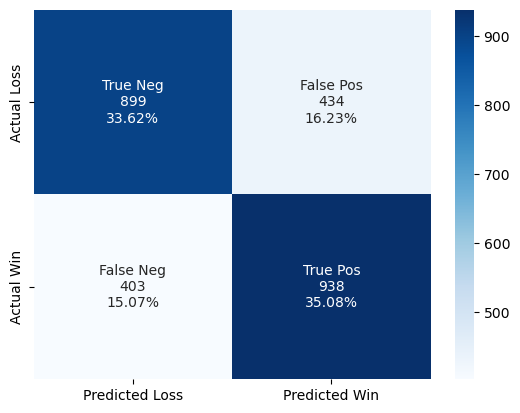

In [64]:
evaluate_classification(logreg_sub, X_val_full_sub, y_val)

In [65]:
#comparing the reduced variable model to the optimized full variable model
compare_classification(hyp_rfe, logreg_sub, X_val_full_rfe, X_val_full_sub, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6903515332834704     0.6869857890800299     -0.0033657442034404905      Accuracy: Model 1 better
AUC:  0.7460629139387754     0.7444976456642125     -0.0015652682745629365      AUC: Model 1 better


## The optimized RFE model still performs best on accuracy, lets try optimizing the reduced varible model

In [66]:
#create function to optimize

def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    model.fit(X_train_full_sub, y_train)
    y_pred = model.predict(X_val_full_sub)
    return accuracy_score(y_val, y_pred)


In [67]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['saga',
                                   'liblinear',
                                  'lbfgs',
                                  'sag']),
    'C': hp.uniform('C', 0.0, 0.6),
    'max_iter': 5000,
    'random_state': 42,
}


In [68]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                     
0.6862378459237098                                                            
{'C': 0.3720713986059846, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
1                                                                             
new best:                                                                     
0.6869857890800299                                                            
{'C': 0.04419661527031447, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
3                                                                             
100%|████| 200/200 [00:06<00:00, 33.19trial/s, best loss: -0.6869857890800299]
best:
{'C': 0.04419661527031447, 'penalty': 0, 'solver': 0}


In [69]:
#examine best parameters
best3 = space_eval(space, best)
best3

{'C': 0.04419661527031447,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga'}

In [70]:
#train model using best parameters
hyp_sub = LogisticRegression(C = best3['C'],
                  max_iter = best3['max_iter'],
                  penalty = best3['penalty'],
                  solver = best3['solver'],
                  random_state =  best3['random_state'])

hyp_sub.fit(X_train_full_sub, y_train)

LogisticRegression(C=0.04419661527031447, max_iter=5000, random_state=42,
                   solver='saga')

In [71]:
y_pred = hyp_sub.predict(X_train_full_sub)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))


Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3197
           1       0.68      0.68      0.68      3218

    accuracy                           0.68      6415
   macro avg       0.68      0.68      0.68      6415
weighted avg       0.68      0.68      0.68      6415



In [72]:
y_pred = hyp_sub.predict(X_val_full_sub)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_sub).split('(')[0])
print('\n', classification_report(y_val, y_pred))


Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.67      0.68      1333
           1       0.68      0.70      0.69      1341

    accuracy                           0.69      2674
   macro avg       0.69      0.69      0.69      2674
weighted avg       0.69      0.69      0.69      2674



Model Performance

Accuracy =  0.6869857890800299 

Classification Report

              precision    recall  f1-score   support

           0     0.6908    0.6737    0.6821      1333
           1     0.6834    0.7002    0.6917      1341

    accuracy                         0.6870      2674
   macro avg     0.6871    0.6869    0.6869      2674
weighted avg     0.6871    0.6870    0.6869      2674



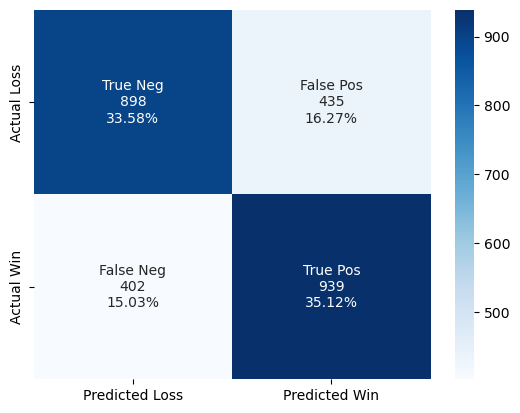

In [73]:
evaluate_classification(hyp_sub, X_val_full_sub, y_val)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

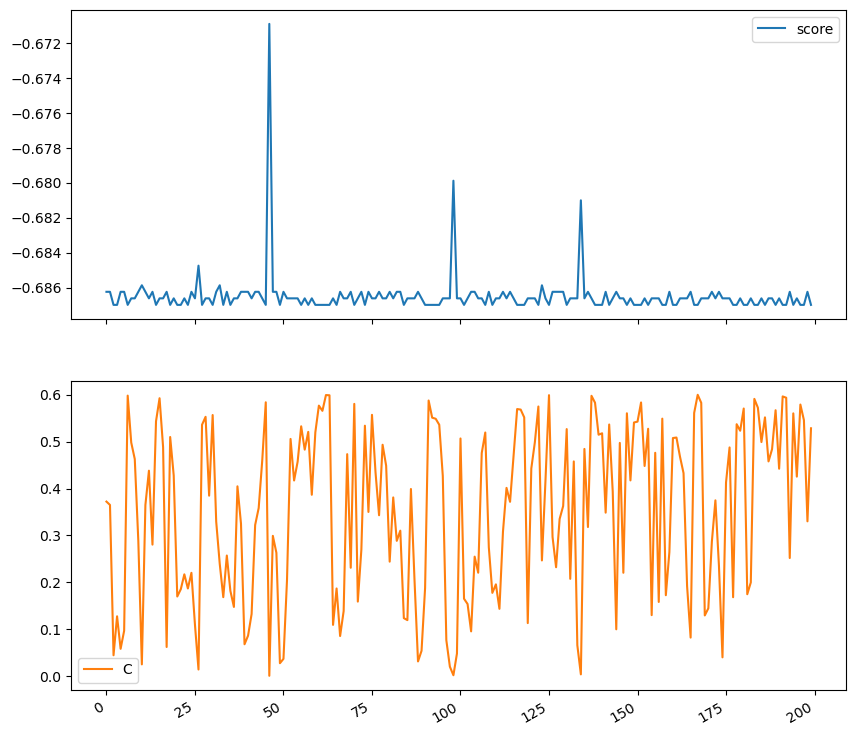

In [74]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

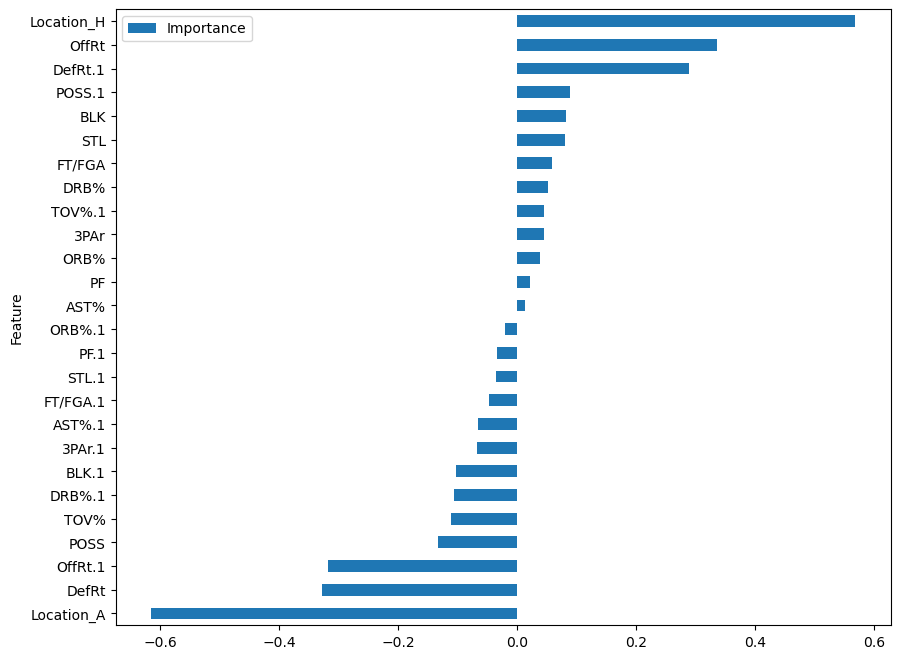

In [75]:
#examining variable importance
coefficients = hyp_sub.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full_sub.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()


In [76]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
24  Location_A   -0.616105
11       DefRt   -0.329032
22     OffRt.1   -0.318627
9         POSS   -0.132852
3         TOV%   -0.112102
18      DRB%.1   -0.106068
13       BLK.1   -0.102532
20      3PAr.1   -0.068347
19      AST%.1   -0.066791
17    FT/FGA.1   -0.047444
12       STL.1   -0.035990
14        PF.1   -0.033953
16      ORB%.1   -0.020569
7         AST%    0.013686
2           PF    0.021641
4         ORB%    0.038553
8         3PAr    0.044458
15      TOV%.1    0.045226
6         DRB%    0.050925
5       FT/FGA    0.058387
0          STL    0.079572
1          BLK    0.081706
21      POSS.1    0.088500
23     DefRt.1    0.288805
10       OffRt    0.335253
25  Location_H    0.568276


In [77]:
#comparing the optimized reduced variable model to the optimized full variable model
compare_classification(hyp_rfe, hyp_sub, X_val_full_rfe, X_val_full_sub, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6903515332834704     0.6869857890800299     -0.0033657442034404905      Accuracy: Model 1 better
AUC:  0.7460629139387754     0.7446442147449615     -0.0014186991938139881      AUC: Model 1 better


## The optimized RFE model still performs the best.

## Now that we have all of our models optimized, we can finally evaluate how they perform on the test data

In [78]:
mods = [logreg,
        hyp_logreg,
        logreg_rfe,
        hyp_rfe,
        logreg_sub,
        hyp_sub]

feats = [X_test_full,
         X_test_full,
         X_test_full_rfe,
         X_test_full_rfe,
         X_test_full_sub,
         X_test_full_sub]

outcomes = y_test

test_evaluation = evaluate_test(mods, feats, outcomes)

In [79]:
test_evaluation

,model_name,model,data_name,data,acc,auc,acc_rank,auc_rank
5,hyp_sub,"LogisticRegression(C=0.04419661527031447, max_...",X_test_full_sub,"{'STL': {0: -0.4341004681723353, 1: -0.3675632...",0.670200,0.737890,1.0,3.0
4,logreg_sub,"LogisticRegression(max_iter=5000, random_state...",X_test_full_sub,"{'STL': {0: -0.4341004681723353, 1: -0.3675632...",0.669576,0.737713,2.0,4.0
0,logreg,"LogisticRegression(max_iter=1000, random_state...",X_test_full,"{'FG': {0: -0.3885476867169027, 1: 0.053619001...",0.665835,0.732056,3.0,5.0
3,hyp_rfe,"LogisticRegression(C=0.012638465688060376, max...",X_test_full_rfe,"{'FG': {0: -0.3885476867169027, 1: 0.053619001...",0.663965,0.737995,4.0,2.0
1,hyp_logreg,"LogisticRegression(C=0.010308206613656157, max...",X_test_full,"{'FG': {0: -0.3885476867169027, 1: 0.053619001...",0.663342,0.738249,5.0,1.0
2,logreg_rfe,"LogisticRegression(max_iter=5000, random_state...",X_test_full_rfe,"{'FG': {0: -0.3885476867169027, 1: 0.053619001...",0.662718,0.731562,6.0,6.0


In [80]:
best_index = test_evaluation.index.values.astype(int)[0]
best_model = test_evaluation['model'].loc[best_index]
best_params = test_evaluation['model'].loc[best_index].get_params()
best_data = pd.DataFrame(test_evaluation['data'].loc[best_index])

In [82]:
best_model

LogisticRegression(C=0.04419661527031447, max_iter=5000, random_state=42,
                   solver='saga')

# Conclusion

## After exploring the variable relationships and variable importance graphs, it appears there playing location and offensive and defense rating are the most valuable features. This makes sense when you consider 'home court advantage' as well as the fact that offensive and defense rating take into account a multitude of both offensive and defense statistics. The reduced variable optimized model performed best on the test data

## Next notebook will explore using a Gradient boosting model